In [23]:
# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.17.0


In [24]:
# Unzip images, ignore this cell if files are already in the workspace
!unzip archive.zip

Archive:  archive.zip
   creating: archive/
   creating: archive/leapGestRecog/
   creating: archive/leapGestRecog/00/
   creating: archive/leapGestRecog/00/01_palm/
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0001.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0002.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0003.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0004.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0005.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0006.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0007.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0008.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0009.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0010.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0011.png  
  inflating: archive/leapGestRecog/00/01_palm/frame_00_01_0012.png  
  infl

In [25]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False):
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

2000


In [26]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)
  plot_image(imagepaths[0]) #We plot the first image from our imagepaths array


In [27]:
# Assuming imagepaths is already defined and contains valid paths
X = []  # Image data
y = []  # Labels

# Check if imagepaths is empty
if not imagepaths:
    print("No image paths found. Please check your image paths.")
else:
    # Loop through image paths to load images and labels into arrays
    for path in imagepaths:
        # Try loading and processing each image
        try:
            img = cv2.imread(path)  # Reads image and returns np.array

            # Check if the image was loaded successfully
            if img is None:
                print(f"Failed to load image: {path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            img = cv2.resize(img, (320, 120))  # Resize image
            X.append(img)  # Append image to data list

            # Process the label
            category = path.split("/")[3]
            label = int(category.split("_")[0][1])  # Extract label
            y.append(label)  # Append label to list

        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

    # Convert X and y into numpy arrays
    X = np.array(X, dtype="uint8")
    X = X.reshape(len(X), 120, 320, 1)  # Reshape for CNN input
    y = np.array(y)

    # Output details for debugging
    print("Images loaded: ", len(X))
    print("Labels loaded: ", len(y))

    if len(y) > 0:
        print(y[0], imagepaths[0])  # Display first label and path for debugging
    else:
        print("No labels were loaded. Check image paths and labels.")


Images loaded:  2000
Labels loaded:  2000
3 ./archive/leapGestRecog/03/02_l/frame_03_02_0002.png


In [28]:
# Confirm images and labels loaded correctly
if len(X) == 0 or len(y) == 0:
    print("No images or labels found. Please check the `imagepaths` and image loading process.")
else:
    # Proceed with train-test split
    ts = 0.3  # Percentage of images that we want to use for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

    # Print to confirm split sizes
    print("Training set size:", len(X_train))
    print("Test set size:", len(X_test))


Training set size: 1400
Test set size: 600


In [29]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


In [30]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [31]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [32]:
from sklearn.model_selection import train_test_split

# Re-check if X and y have data
if len(X) == 0 or len(y) == 0:
    print("Data not loaded properly into X and y. Check the image paths or data loading process.")
else:
    ts = 0.3  # Test size for splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

# Proceed only if train_test_split was successful
if 'X_train' in locals():
    # Define and compile your model if not already done
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 320, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Adjust based on your label classes

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))


Epoch 1/5
22/22 - 53s - 2s/step - accuracy: 0.0971 - loss: -2.7942e+05 - val_accuracy: 0.1067 - val_loss: -7.5819e+05
Epoch 2/5
22/22 - 79s - 4s/step - accuracy: 0.0971 - loss: -2.0654e+06 - val_accuracy: 0.1067 - val_loss: -3.7603e+06
Epoch 3/5
22/22 - 87s - 4s/step - accuracy: 0.0971 - loss: -7.6502e+06 - val_accuracy: 0.1067 - val_loss: -1.1847e+07
Epoch 4/5
22/22 - 48s - 2s/step - accuracy: 0.0971 - loss: -2.0542e+07 - val_accuracy: 0.1067 - val_loss: -2.8610e+07
Epoch 5/5
22/22 - 82s - 4s/step - accuracy: 0.0971 - loss: -4.4918e+07 - val_accuracy: 0.1067 - val_loss: -5.7981e+07


In [33]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.1127 - loss: -60399304.0000
Test accuracy: 10.67%


In [34]:
predictions = model.predict(X_test) # Make predictions towards the test set

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step


In [35]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(0, 4)

In [36]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"]
  plt.figure(figsize=(15,5))

  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction

    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

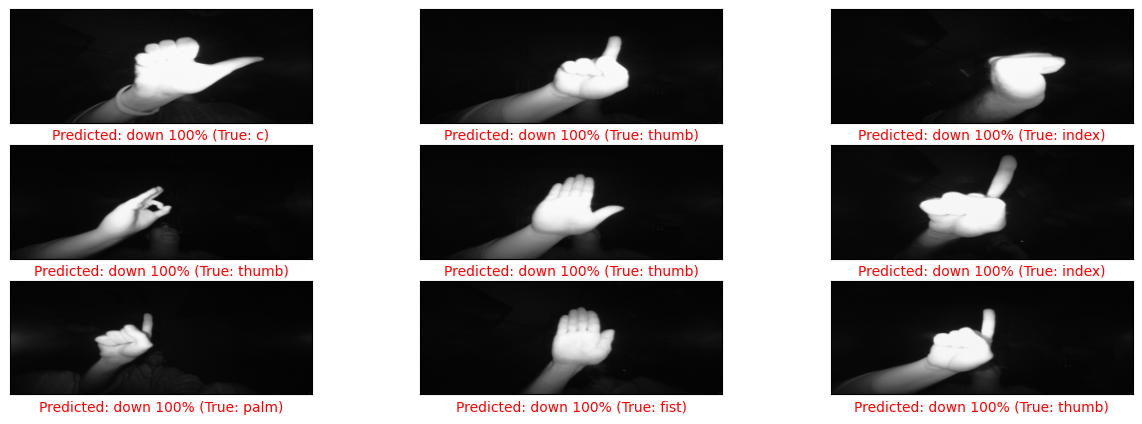

In [37]:
validate_9_images(predictions, y_test, X_test)

In [38]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [39]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,62,0,0,0,0,0,0,0,0,0
Actual Palm (H),64,0,0,0,0,0,0,0,0,0
Actual L,72,0,0,0,0,0,0,0,0,0
Actual Fist (H),52,0,0,0,0,0,0,0,0,0
Actual Fist (V),66,0,0,0,0,0,0,0,0,0
Actual Thumbs up,57,0,0,0,0,0,0,0,0,0
Actual Index,54,0,0,0,0,0,0,0,0,0
Actual OK,55,0,0,0,0,0,0,0,0,0
Actual Palm (V),49,0,0,0,0,0,0,0,0,0
Actual C,69,0,0,0,0,0,0,0,0,0
